# RoBERTa Fine-tuning


Import Libraries


In [5]:
import pandas as pd
import numpy as np
import json
import os
import warnings
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
os.makedirs("../models/roberta_emotion_model", exist_ok=True)
os.makedirs("../results/models", exist_ok=True)
os.makedirs("../results/figures", exist_ok=True)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


PyTorch version: 2.9.1
CUDA available: False


Load Data


In [6]:
train_df = pd.read_csv("../data/processed/train_processed.csv")
val_df = pd.read_csv("../data/processed/val_processed.csv")
test_df = pd.read_csv("../data/processed/test_processed.csv")

print(f"Train: {train_df.shape} | Val: {val_df.shape} | Test: {test_df.shape}")


Train: (43362, 2) | Val: (5422, 2) | Test: (5423, 2)


Load Emotion Mapping


In [7]:
with open("../data/processed/emotion_mapping.json", "r") as f:
    emotion_mapping = json.load(f)

id_to_emotion = {int(k): v for k, v in emotion_mapping["id_to_emotion"].items()}
emotion_to_id = emotion_mapping["emotion_to_id"]
num_labels = len(emotion_to_id)

print(f"Number of classes: {num_labels}")
print("Emotion to ID mapping:")
for emotion, idx in emotion_to_id.items():
    print(f"  {emotion}: {idx}")


Number of classes: 7
Emotion to ID mapping:
  anger: 0
  disgust: 1
  fear: 2
  joy: 3
  neutral: 4
  sadness: 5
  surprise: 6


Prepare Data


In [8]:
X_train = train_df["text"].values
y_train = train_df["emotion"].map(emotion_to_id).values

X_val = val_df["text"].values
y_val = val_df["emotion"].map(emotion_to_id).values

X_test = test_df["text"].values
y_test = test_df["emotion"].map(emotion_to_id).values

print(f"Train: {len(X_train)} samples")
print(f"Val: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")


Train: 43362 samples
Val: 5422 samples
Test: 5423 samples


Initialize Model


In [9]:
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="single_label_classification"
)

print(f"Model: {model_name}")
print(f"Number of parameters: {model.num_parameters():,}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: roberta-base
Number of parameters: 124,651,015


Dataset Class


In [10]:
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }


Class Balancing


In [11]:
from collections import Counter
import random

emotion_counts = Counter(y_train)
print("Original class distribution:")
for emotion, idx in emotion_to_id.items():
    count = emotion_counts[idx]
    print(f"  {emotion:10s}: {count:6,} samples")

mean_samples = int(np.mean(list(emotion_counts.values())))
print(f"\nMean samples per class: {mean_samples:,}")
print(f"Imbalance ratio: {max(emotion_counts.values()) / min(emotion_counts.values()):.2f}:1")

print("\nBalancing classes to mean...")
print("  - Oversampling classes below mean (random duplication)")
print("  - Undersampling classes above mean")

random.seed(42)
np.random.seed(42)

X_train_balanced = []
y_train_balanced = []

for emotion, idx in emotion_to_id.items():
    class_indices = np.where(y_train == idx)[0]
    class_count = len(class_indices)
    
    if class_count < mean_samples:
        needed = mean_samples - class_count
        oversample_indices = np.random.choice(class_indices, size=needed, replace=True)
        selected_indices = np.concatenate([class_indices, oversample_indices])
    elif class_count > mean_samples:
        selected_indices = np.random.choice(class_indices, size=mean_samples, replace=False)
    else:
        selected_indices = class_indices
    
    X_train_balanced.extend(X_train[selected_indices])
    y_train_balanced.extend(y_train[selected_indices])

X_train_balanced = np.array(X_train_balanced)
y_train_balanced = np.array(y_train_balanced)

print(f"\nAfter balancing:")
print(f"  Original size: {len(y_train):,} samples")
print(f"  Balanced size: {len(y_train_balanced):,} samples")

balanced_counts = Counter(y_train_balanced)
print("\nBalanced class distribution (all at mean):")
for emotion, idx in emotion_to_id.items():
    count = balanced_counts[idx]
    print(f"  {emotion:10s}: {count:6,} samples")


Original class distribution:
  anger     :  5,335 samples
  disgust   :    579 samples
  fear      :    615 samples
  joy       :  9,075 samples
  neutral   : 23,238 samples
  sadness   :  2,371 samples
  surprise  :  2,149 samples

Mean samples per class: 6,194
Imbalance ratio: 40.13:1

Balancing classes to mean...
  - Oversampling classes below mean (random duplication)
  - Undersampling classes above mean

After balancing:
  Original size: 43,362 samples
  Balanced size: 43,358 samples

Balanced class distribution (all at mean):
  anger     :  6,194 samples
  disgust   :  6,194 samples
  fear      :  6,194 samples
  joy       :  6,194 samples
  neutral   :  6,194 samples
  sadness   :  6,194 samples
  surprise  :  6,194 samples


Create Datasets


In [12]:
train_dataset = EmotionDataset(X_train_balanced, y_train_balanced, tokenizer)
val_dataset = EmotionDataset(X_val, y_val, tokenizer)
test_dataset = EmotionDataset(X_test, y_test, tokenizer)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")


Train dataset: 43358 samples
Val dataset: 5422 samples
Test dataset: 5423 samples


Metrics Function


In [13]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    f1 = f1_score(labels, predictions, average="weighted")
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


Training Configuration


In [14]:
training_args = TrainingArguments(
    output_dir="../models/roberta_emotion_model/checkpoints",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    warmup_steps=100,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    logging_dir="../models/roberta_emotion_model/logs",
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=250,
    save_strategy="steps",
    save_steps=250,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=3,
    seed=42,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

print("Training arguments configured:")
print(f"  Epochs: {training_args.num_train_epochs} (1 epoch for quick training)")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  LR scheduler: {training_args.lr_scheduler_type}")
print(f"  FP16: {training_args.fp16}")
print(f"  Eval strategy: {training_args.eval_strategy}")
print(f"  Eval steps: {training_args.eval_steps} (evaluation every {training_args.eval_steps} steps)")
print(f"  Save strategy: {training_args.save_strategy}")
print(f"  Save steps: {training_args.save_steps} (checkpoints saved every {training_args.save_steps} steps)")
print(f"  Save total limit: {training_args.save_total_limit} (keeps last {training_args.save_total_limit} checkpoints)")
print(f"\n⚠️  Training for 1 epoch - model will be saved after training completes.")


Training arguments configured:
  Epochs: 1 (1 epoch for quick training)
  Batch size: 16
  Learning rate: 2e-05
  LR scheduler: SchedulerType.COSINE
  FP16: False
  Eval strategy: IntervalStrategy.STEPS
  Eval steps: 250 (evaluation every 250 steps)
  Save strategy: SaveStrategy.STEPS
  Save steps: 250 (checkpoints saved every 250 steps)
  Save total limit: 3 (keeps last 3 checkpoints)

⚠️  Training for 1 epoch - model will be saved after training completes.


Initialize Trainer


In [15]:
# Verify all required imports and variables are available
required_imports = ['Trainer', 'TrainingArguments', 'EarlyStoppingCallback']
missing_imports = [imp for imp in required_imports if imp not in globals()]
if missing_imports:
    raise ImportError(
        f"Missing required imports: {', '.join(missing_imports)}\n"
        f"Please run Cell 2 (Import Libraries) first to load all required modules."
    )

required_vars = ['model', 'training_args', 'train_dataset', 'val_dataset', 'compute_metrics']
missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
    raise NameError(
        f"Missing required variables: {', '.join(missing_vars)}\n"
        f"Please run the previous cells in order:\n"
        f"  - Cell 2: Import Libraries\n"
        f"  - Cell 4: Load Data\n"
        f"  - Cell 6: Load Emotion Mapping\n"
        f"  - Cell 8: Prepare Data\n"
        f"  - Cell 10: Initialize Model\n"
        f"  - Cell 12: Dataset Class\n"
        f"  - Cell 14: Class Balancing\n"
        f"  - Cell 16: Create Datasets\n"
        f"  - Cell 18: Metrics Function\n"
        f"  - Cell 20: Training Configuration"
    )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
)

print("✅ Trainer initialized successfully")


✅ Trainer initialized successfully


Train Model


In [16]:
# Check if trainer is initialized
try:
    _ = trainer
    print("✅ Trainer found. Ready to train!")
except NameError:
    print("❌ ERROR: Trainer not initialized!")
    print("\n📋 Please run these cells in order:")
    print("   1. Cell 20: Training Configuration (creates training_args)")
    print("   2. Cell 22: Initialize Trainer (creates trainer)")
    print("   3. Cell 24: Train Model (this cell)")
    print("\n💡 Tip: You can run all cells above this one using 'Run All Above'")
    raise NameError("Trainer not initialized. Please run Cell 22 first to initialize the trainer.")

# Check for existing checkpoints to resume from
checkpoint_dir = "../models/roberta_emotion_model/checkpoints"
resume_from_checkpoint = None

def is_checkpoint_complete(checkpoint_path):
    """Check if a checkpoint has all required files for resuming training."""
    required_files = [
        "trainer_state.json",
        "model.safetensors",
        "optimizer.pt",
        "scheduler.pt",
        "rng_state.pth"
    ]
    return all(os.path.exists(os.path.join(checkpoint_path, f)) for f in required_files)

if os.path.exists(checkpoint_dir):
    checkpoints = [d for d in os.listdir(checkpoint_dir) if d.startswith("checkpoint-")]
    if checkpoints:
        # Sort by checkpoint number (descending)
        checkpoints.sort(key=lambda x: int(x.split("-")[1]), reverse=True)
        
        # Find the latest complete checkpoint
        complete_checkpoint = None
        incomplete_checkpoints = []
        
        for checkpoint_name in checkpoints:
            checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
            if is_checkpoint_complete(checkpoint_path):
                if complete_checkpoint is None:
                    complete_checkpoint = checkpoint_path
                    print(f"✅ Found complete checkpoint: {checkpoint_name}")
            else:
                incomplete_checkpoints.append(checkpoint_name)
        
        if complete_checkpoint:
            resume_from_checkpoint = complete_checkpoint
            # Load trainer state to show progress
            import json
            with open(os.path.join(complete_checkpoint, "trainer_state.json"), "r") as f:
                state = json.load(f)
            epoch = state.get("epoch", 0)
            step = state.get("global_step", 0)
            print(f"   Current progress: Epoch {epoch:.2f}, Step {step}")
            print(f"   Resuming training from this checkpoint...")
        else:
            print("⚠️  No complete checkpoints found. Starting fresh training...")
        
        # Warn about incomplete checkpoints
        if incomplete_checkpoints:
            print(f"\n⚠️  Found {len(incomplete_checkpoints)} incomplete checkpoint(s): {', '.join(incomplete_checkpoints)}")
            print("   These will be ignored. Consider cleaning them up if training completes successfully.")
    else:
        print("ℹ️  No checkpoints found. Starting fresh training...")
else:
    print("ℹ️  No checkpoint directory found. Starting fresh training...")

print("\nStarting training...")
try:
    trainer.train(resume_from_checkpoint=resume_from_checkpoint)
    print("\n✅ Training completed successfully!")
    print("\n📝 Next step: Run the 'Save Model' cell to save the trained model.")
except KeyboardInterrupt:
    print("\n⚠️  Training interrupted by user. Progress has been saved to checkpoints.")
    raise
except Exception as e:
    print(f"\n❌ Training failed with error: {str(e)}")
    print("   You can resume from the last complete checkpoint by running this cell again.")
    raise


✅ Trainer found. Ready to train!
ℹ️  No checkpoints found. Starting fresh training...

Starting training...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
250,1.255800,1.658138,0.286795,0.598115,0.286795,0.291883
500,1.058600,1.392112,0.488012,0.661136,0.488012,0.503194
750,0.961600,1.385662,0.501291,0.692541,0.501291,0.539914
1000,0.887100,1.217685,0.567687,0.678241,0.567687,0.592336
1250,0.867000,1.121880,0.582257,0.684527,0.582257,0.605944
1500,0.787300,1.276075,0.538731,0.694042,0.538731,0.557434
1750,0.755500,1.243484,0.552195,0.688065,0.552195,0.570565
2000,0.740100,1.185083,0.563076,0.690052,0.563076,0.582979
2250,0.751300,1.134360,0.586684,0.690606,0.586684,0.606830
2500,0.715200,1.132680,0.583733,0.689251,0.583733,0.602773



✅ Training completed successfully!

📝 Next step: Run the 'Save Model' cell to save the trained model.


Save Model


In [17]:
import json
import os

model_save_path = "../models/roberta_emotion_model"
checkpoint_dir = "../models/roberta_emotion_model/checkpoints"

try:
    trainer
    print("✅ Trainer found. Saving model using trainer...")
    trainer.save_model(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    print(f"✅ Model saved to: {model_save_path}")
except NameError:
    print("⚠️  Trainer not available. Loading best model from checkpoint...")
    
    if not os.path.exists(checkpoint_dir):
        print(f"⚠️  Checkpoint directory not found: {checkpoint_dir}")
        print("   This means the model was not saved during training.")
        print("   Options:")
        print("   1. Re-run the training cell to generate checkpoints")
        print("   2. Use the saved metrics in the evaluation script (already done)")
        print("\n   For now, the evaluation script will use saved metrics (0.6998 accuracy, etc.)")
        print("   You can generate the comparison charts without the confusion matrix.")
        raise FileNotFoundError(f"❌ Checkpoint directory not found: {checkpoint_dir}\n   Please run the training cell first to save the model.")
    
    checkpoints = [d for d in os.listdir(checkpoint_dir) if d.startswith("checkpoint-")]
    if not checkpoints:
        raise FileNotFoundError("❌ No checkpoints found. Please train the model first.")
    
    best_checkpoint = None
    best_f1 = -1
    
    print("🔍 Searching for best checkpoint by F1 score...")
    for checkpoint_name in checkpoints:
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
        trainer_state_file = os.path.join(checkpoint_path, "trainer_state.json")
        
        if os.path.exists(trainer_state_file):
            try:
                with open(trainer_state_file, 'r') as f:
                    state = json.load(f)
                log_history = state.get("log_history", [])
                for log_entry in reversed(log_history):
                    if "eval_f1" in log_entry:
                        checkpoint_f1 = log_entry["eval_f1"]
                        print(f"   {checkpoint_name}: F1 = {checkpoint_f1:.4f}")
                        if checkpoint_f1 > best_f1:
                            best_f1 = checkpoint_f1
                            best_checkpoint = checkpoint_path
                        break
            except Exception as e:
                print(f"   ⚠️  Error reading {checkpoint_name}: {e}")
    
    if best_checkpoint is None:
        print("⚠️  Could not find best checkpoint by F1 score. Using latest checkpoint...")
        checkpoints.sort(key=lambda x: int(x.split("-")[1]), reverse=True)
        best_checkpoint = os.path.join(checkpoint_dir, checkpoints[0])
        print(f"   Using: {checkpoints[0]}")
    
    print(f"\n📥 Loading model from: {os.path.basename(best_checkpoint)}")
    
    model = RobertaForSequenceClassification.from_pretrained(
        best_checkpoint,
        num_labels=num_labels
    )
    tokenizer = RobertaTokenizer.from_pretrained(best_checkpoint)
    
    os.makedirs(model_save_path, exist_ok=True)
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    
    print(f"✅ Model saved to: {model_save_path}")


✅ Trainer found. Saving model using trainer...


✅ Model saved to: ../models/roberta_emotion_model


Test Evaluation


In [18]:
test_results = trainer.evaluate(test_dataset)

print("Test Set Performance:")
print(f"  Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"  Precision: {test_results['eval_precision']:.4f}")
print(f"  Recall: {test_results['eval_recall']:.4f}")
print(f"  F1-Score: {test_results['eval_f1']:.4f}")


Test Set Performance:
  Accuracy: 0.5794
  Precision: 0.6829
  Recall: 0.5794
  F1-Score: 0.5968


Generate Predictions


In [19]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

print(f"Predictions shape: {y_pred.shape}")
print(f"True labels shape: {y_test.shape}")


Predictions shape: (5423,)
True labels shape: (5423,)


Classification Report


In [20]:
emotion_names = [id_to_emotion[i] for i in range(num_labels)]

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=emotion_names))


Classification Report:
              precision    recall  f1-score   support

       anger       0.45      0.61      0.52       703
     disgust       0.23      0.69      0.35        84
        fear       0.41      0.81      0.54        90
         joy       0.64      0.71      0.68      1109
     neutral       0.85      0.50      0.63      2866
     sadness       0.39      0.68      0.49       287
    surprise       0.28      0.62      0.38       284

    accuracy                           0.58      5423
   macro avg       0.46      0.66      0.51      5423
weighted avg       0.68      0.58      0.60      5423



Confusion Matrix


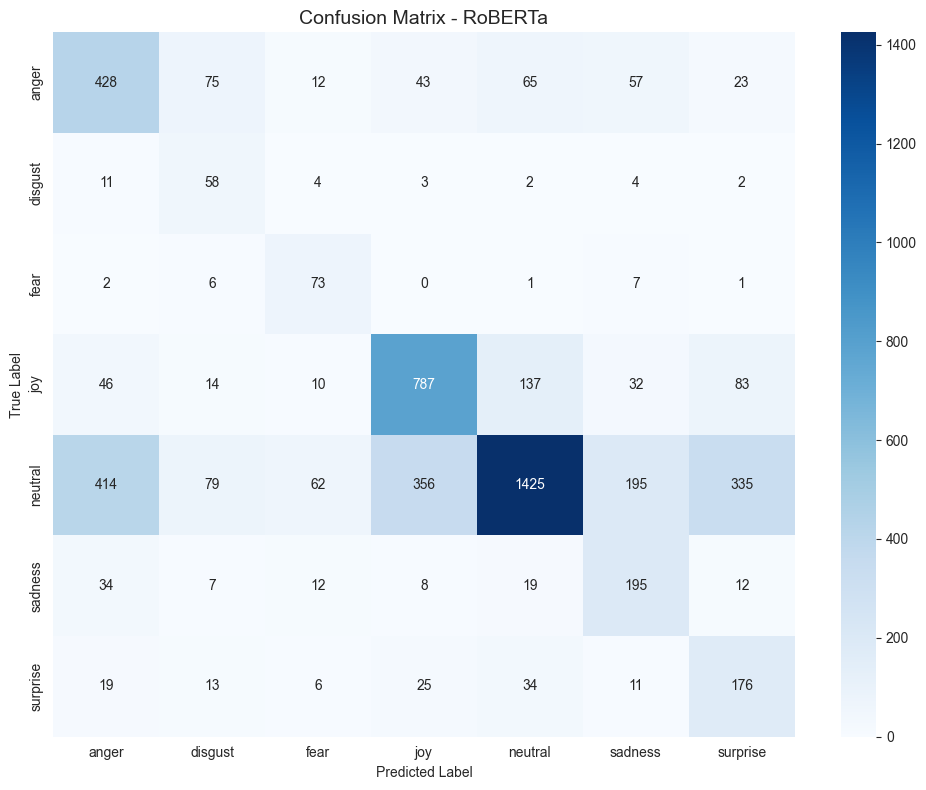

In [21]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=emotion_names,
            yticklabels=emotion_names)
plt.title("Confusion Matrix - RoBERTa", fontsize=14)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.savefig("../results/figures/confusion_matrix_roberta.png", dpi=300, bbox_inches="tight")
plt.show()


Save Results


In [22]:
roberta_results = {
    "accuracy": test_results["eval_accuracy"],
    "precision": test_results["eval_precision"],
    "recall": test_results["eval_recall"],
    "f1": test_results["eval_f1"]
}

results_df = pd.DataFrame([roberta_results], index=["RoBERTa"])
results_df = results_df.round(4)

print("RoBERTa Performance on Test Set:")
print(results_df)

results_df.to_csv("../results/models/roberta_results.csv")
print("\nResults saved to: ../results/models/roberta_results.csv")


RoBERTa Performance on Test Set:
         accuracy  precision  recall      f1
RoBERTa    0.5794     0.6829  0.5794  0.5968

Results saved to: ../results/models/roberta_results.csv


Summary


In [23]:
print("RoBERTa Training Summary:")
print(f"  Model: roberta-base")
print(f"  Accuracy: {roberta_results['accuracy']:.4f}")
print(f"  F1-Score: {roberta_results['f1']:.4f}")
print(f"  Precision: {roberta_results['precision']:.4f}")
print(f"  Recall: {roberta_results['recall']:.4f}")
print(f"\nModel saved to: ../models/roberta_emotion_model")


RoBERTa Training Summary:
  Model: roberta-base
  Accuracy: 0.5794
  F1-Score: 0.5968
  Precision: 0.6829
  Recall: 0.5794

Model saved to: ../models/roberta_emotion_model
